In [116]:
import numpy as np
import matplotlib.pyplot as plt
import numba 
import tqdm
import scipy as scipy
# import njit

In [142]:
SWEEPS = 50_000
TAU = 300
DTAU = 1
NTAU = int(TAU/DTAU)
HIT = 0.1
ALPHA = 0.4

XMIN = -4
XMAX = 4
NXBINS = 1000
OMEGA = 1
M = 1
DX = (XMAX - XMIN) / NXBINS
prob_hist = np.zeros(NXBINS)

x_bins = np.linspace(XMIN, XMAX, NXBINS + 1)
x_path = np.zeros(NTAU)
x = np.linspace(XMIN, XMAX, NXBINS + 1)
MCMCAvg = []
# print(NTAU)



In [143]:
# Potential Well
def V(x):
    return ALPHA * x**4 - 2 * x**2 + 1/ALPHA

# Define Path Variance
def vary_path(x_i):
    x_prime = x_i + np.random.random() * 2 * HIT - HIT
    while x_prime > XMAX or x_prime < XMIN:
        x_prime = x_i + np.random.random() * 2 * HIT - HIT
    return x_prime

# Define our Action S
def Action(left, right):
    K = 0.5 * M * (((right - left)**2) / DTAU)
    v = 0.5 * M * DTAU * (OMEGA**2) * V((left + right) / 2)
    return K + v

# Define the total action 
def total_action(x_path):
    path_action = 0
    for i in range(-1, NTAU-1):
        path_action += Action(x_path[i], x_path[i+1])
    return path_action
                   
# Define difference in action
def delta_action(x_path, x_prime, i):
    left = x_path[i-1]
    right = x_path[i+1] if i < NTAU-1 else x_path[0]
    daction = Action(left, x_prime) + Action(x_prime, right)
    daction -= Action(left, x_path[i]) + Action(x_path[i], right)
    return daction
                   
# Calculate Ground State using MCMC histogram
def Ground(state):
    norm = state / np.sum(state * DX)
    K = np.real(0.5 * np.sum(DX * np.diff(np.sqrt(norm))*np.diff(np.sqrt(norm)) / DX**2))
    VG = np.sum(norm * V(x[:-1])) * DX
    E_0 = 0.5 * (K + VG)
    return E_0

# Define MCMC function
def MCMC(x_path, prob_hist):
    for i in range(NTAU):
        x_prime = vary_path(x_path[i])
        daction = delta_action(x_path, x_prime, i)
        if daction <= 0:
            x_path[i] = x_prime
        else: 
            prob = np.exp(-daction)
            if np.random.random() < prob:
                x_path[i] = x_prime
    hist, _ = np.histogram(x_path, bins = x_bins)
    prob_hist += hist
    MCMCAvg.append(np.mean([(i**2 / 2) if i != 0 else x_path[idx - 1] ** 2 for idx, i in enumerate(x_path)]))
#     E0_list.append()
#     S_list.append(total_action(x_path)/NTAU)
    


In [144]:
# Create expected dist.
H = np.zeros((NXBINS + 1, NXBINS + 1))
for i in range(NXBINS + 1):
    for j in range(NXBINS + 1):
        H[i,j] = - (0.5 / DX**2) * ((i + 1 == j) - 2 * (i == j) + (i - 1 == j))
        H[i,j] += V(x[i]) * (i == j)

Es, psis = scipy.sparse.linalg.eigsh(H, k=2, sigma=1.5, which='LM')

E0 = Es[0]
psi0 = psis[:,0]

# normalize psi0
psi0 /= np.sqrt(np.sum(psi0.conjugate() * psi0) * DX)
normed = np.abs(psi0)**2
normed /= np.sum(normed) * DX

In [145]:
E0_list = []
S_list = []

for k in tqdm.tqdm(range(int(SWEEPS))):
    MCMC(x_path, prob_hist)

100%|████████████████████████████████████| 50000/50000 [03:17<00:00, 253.31it/s]


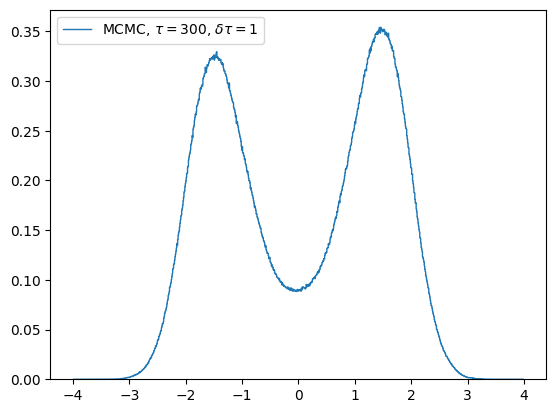

In [146]:
plt.figure()
plt.stairs(prob_hist/np.sum(prob_hist*DX), x_bins, label=f"MCMC, $\\tau = {TAU}$, $\\delta\\tau={DTAU}$")
# plt.plot(x_bins, psi_analytical*psi_analytical.conjugate(), label="Analytical")
# plt.plot(x_bins,V(x_bins)/250)
plt.legend()
# plt.savefig('ProbHistogramDeltatau0.1.jpg')
plt.show()


In [147]:
print(f"\ntau: {NTAU} \nSweeps: {SWEEPS} \n")
print(f"Expected E_0 : {E0}")
print(f"MCMC Evaluated E_0 : {Ground(prob_hist)}")


tau: 300 
Sweeps: 50000 

Expected E_0 : 1.234496389859206
MCMC Evaluated E_0 : 0.8013705382696585


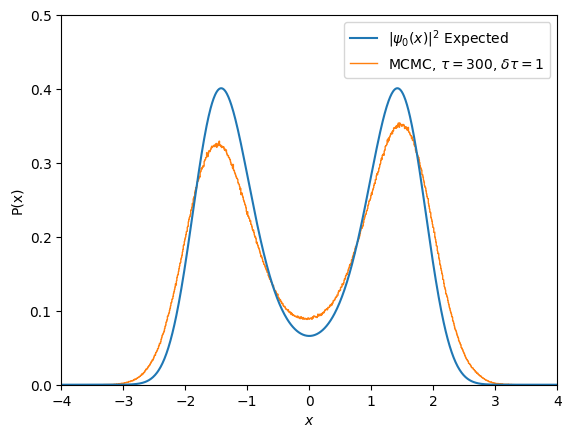

[0.0017792665635861155, 0.0032008286222305906, 0.00472270572106176, 0.006662361254895652, 0.00837535392445155, 0.010446575131155093, 0.011492456684056926, 0.012547136968090974, 0.013853401345399821, 0.015542511562712828, 0.016409270239614953, 0.018413777960866136, 0.019940009214595978, 0.02046683640248994, 0.021602100257312053, 0.022974436255137953, 0.02508791100685092, 0.026598155754633437, 0.02721367354033396, 0.027476772286259395, 0.029872482766825498, 0.03230460559896362, 0.03236116846610679, 0.03414056338074991, 0.03504381268932908, 0.037167758694151266, 0.038661987818966105, 0.038852933577136727, 0.040611050788343005, 0.04318205622330647, 0.045091460477012076, 0.04715403601038646, 0.04512470327461456, 0.04694579752939122, 0.04755648226395742, 0.04890586441429992, 0.05010048453585791, 0.052170963766087354, 0.052469675338581205, 0.05491334672780153, 0.05540260969460484, 0.0569240363572188, 0.057968711878446016, 0.05934200318665572, 0.06093173662612712, 0.061810338742920766, 0.06181

Text(0.5, 0, 'Steps')

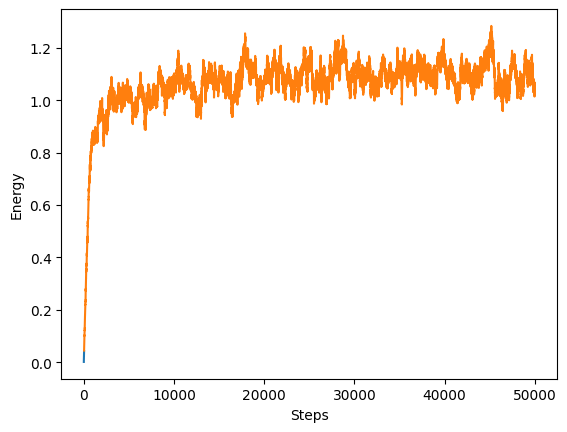

In [148]:
YMIN, YMAX = 0, 0.5 
burnin = int(NTAU/10)

plt.figure()
plt.plot(x, normed, label=r"$|\psi_0(x)|^2$ Expected")
plt.stairs(prob_hist/np.sum(prob_hist*DX), x_bins, label=f"MCMC, $\\tau = {TAU}$, $\\delta\\tau={DTAU}$")
plt.xlabel(r"$x$")
plt.ylabel(r"P(x)")
plt.ylim([YMIN, YMAX])
plt.xlim([XMIN, XMAX])
plt.legend()
plt.show()
print(MCMCAvg)
plt.figure()
plt.plot(range(len(MCMCAvg))[:burnin], MCMCAvg[:burnin])
plt.plot(range(len(MCMCAvg))[burnin:], MCMCAvg[burnin:])
plt.ylabel("Energy")
plt.xlabel("Steps")

In [149]:
print(MCMCAvg)

[0.0017792665635861155, 0.0032008286222305906, 0.00472270572106176, 0.006662361254895652, 0.00837535392445155, 0.010446575131155093, 0.011492456684056926, 0.012547136968090974, 0.013853401345399821, 0.015542511562712828, 0.016409270239614953, 0.018413777960866136, 0.019940009214595978, 0.02046683640248994, 0.021602100257312053, 0.022974436255137953, 0.02508791100685092, 0.026598155754633437, 0.02721367354033396, 0.027476772286259395, 0.029872482766825498, 0.03230460559896362, 0.03236116846610679, 0.03414056338074991, 0.03504381268932908, 0.037167758694151266, 0.038661987818966105, 0.038852933577136727, 0.040611050788343005, 0.04318205622330647, 0.045091460477012076, 0.04715403601038646, 0.04512470327461456, 0.04694579752939122, 0.04755648226395742, 0.04890586441429992, 0.05010048453585791, 0.052170963766087354, 0.052469675338581205, 0.05491334672780153, 0.05540260969460484, 0.0569240363572188, 0.057968711878446016, 0.05934200318665572, 0.06093173662612712, 0.061810338742920766, 0.06181